<font size=7> Latencies Analysis

In [1]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs, latencies
from human_hip.animate import animate_latencies
import human_hip.spike_data as spike_data

import pickle
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
import numpy as np

In [2]:
sd = spike_data.read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112823_avv9hckcr1_21841_120323_3_acqm.zip" )


In [4]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt

#https://medium.com/@dreamferus/how-to-synchronize-time-series-using-cross-correlation-in-python-4c1fd5668c7a#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImM3ZTExNDEwNTlhMTliMjE4MjA5YmM1YWY3YTgxYTcyMGUzOWI1MDAiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDI5NDUwNDY4Mjk4NDg1MzY1NjYiLCJoZCI6InVjc2MuZWR1IiwiZW1haWwiOiJtZWxsaW90MUB1Y3NjLmVkdSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJuYmYiOjE2OTM1MTg3MjksIm5hbWUiOiJNYXR0IEVsbGlvdHQiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUFjSFR0ZWRoeVRrWk1hU1hJRTFqa1hhZEVmbmhxc3NwNW1lVFkzUHV0THluMVJ1TXc9czk2LWMiLCJnaXZlbl9uYW1lIjoiTWF0dCIsImZhbWlseV9uYW1lIjoiRWxsaW90dCIsImxvY2FsZSI6ImVuIiwiaWF0IjoxNjkzNTE5MDI5LCJleHAiOjE2OTM1MjI2MjksImp0aSI6Ijc5NGMxOTk1NmI5NDJiNWQzNGIzODc0YTdjYzQ1ZTgyZTlkNjdjZTYifQ.mrDH7b9_D0YfYF3xxqJl-Kh5w_XeWgpyntt19-Bvs4VJJpuJR5DRRJsSGO52guE8jSdYsSDS_ILzPyY_rZAyivCZ4mXJv3CftxbNxgxRD_feS8BNI3YPbTh2Oin7tj32Gzm75Nq4k-UnhQxy9d7qVlw29DA6Wns1yTY0B6cb0pPEuKMWfHmlmCUEtDEDX0dE__pUGkBxWwickpa2n-pW-Z71y-hatFAn80JrOPclPZj1Yts9xeV9uPC7ICWTjSVLZB4Nl8mKy6Rxn6pB_ny01ne06iAoYidx2SwRU3j5BVZF1CK-bhVqQ-qOuzIPj17qvkFE9RJT9Zw842YN9f16MA
def cross_correlation_max_shift(x, y):
    correlations = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
    return lags[np.argmax(correlations)]

def curate_latencies(sd, cross_sttc_min_cutoff=2, cross_sttc_max_cutoff=15, sttc_cutoff = 0.04, latency_cutoff=1, sigma=15, sttc_delta=20 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
        if abs(np.median(pair_latencies))> latency_cutoff:
            pairs_late.append( pair )  #lags_late.append( latency )
    pairs= pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")

    # Do cross sttc for all pairs
    print("Starting cross_sttc calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs: 
        x = np.around( sd.train[pair[0]] ).astype(int)
        y= np.around( sd.train[pair[1]] ).astype(int)
        x_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
        y_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
        x_long[ x ] = 1
        y_long[ y ] = 1
        x_smooth = gaussian_filter(x_long, sigma=sigma) # sigma=15
        y_smooth = gaussian_filter(y_long, sigma=sigma) # sigma=15
        
        cross_lag.append( cross_correlation_max_shift( x_smooth, y_smooth ) ) 

    cross_lag = np.array(cross_lag)
    to_keep = np.where((np.abs(cross_lag)< cross_sttc_max_cutoff) & (np.abs(cross_lag)> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")
    return np.array(pairs)[ to_keep ] 

In [5]:
# good_pairs = curate_latencies(sd)
# with open( 'hc112823_acid_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
#load pickled data
with open( 'hc112823_acid_good_pairs.pkl' , 'rb') as my_file:
    good_pairs = pickle.load(my_file)
print(len(good_pairs))

44944 Starting Pairs
11079 pairs above sttc cutoff
4965 pairs above latencency cutoff
Starting cross_sttc calculation... might take a minute
449 pairs between cross_sttc cutoffs


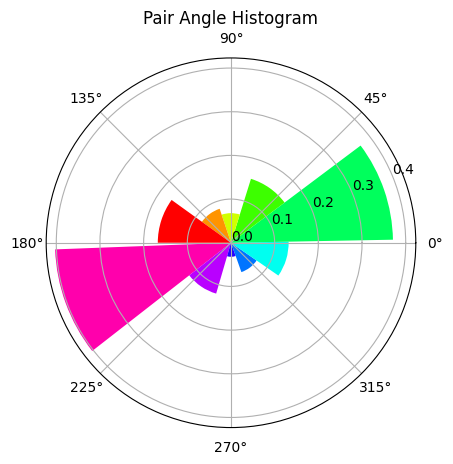

In [6]:
plot_latency_angle_hist( sd, good_pairs)

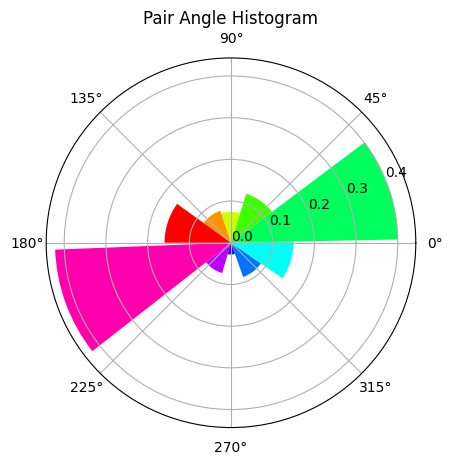

In [7]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=True)

# <font color="brown"> Combine Arrows

In [8]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from sklearn import preprocessing
import numpy as np
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint, cross_sttc
from braingeneers.analysis.analysis import SpikeData
import warnings
import diptest 
import math
import matplotlib.cm as cm
from ipywidgets import interact_manual
from matplotlib.ticker import MaxNLocator

In [9]:

# The function creates  plot of arrows show the direction that information is flowing out of neurons
def plot_vector_layout( sd, pairs, normalize=True, plot_neuron=True, arrow_length=75, min_dist=0, image_path=None, xlim=None, ylim=None, background_color="white" ):
    """
    Inputs:
        pairs: np.array of neuron indices (as pairs) for which a connection exists, ex: [[0,1], [0,2], [2,3]]
        lags: np.array of the average lag time in ms corresponding to the neuron pairs, ex: [1, 3, -4]
        normalize: boolean, if True, all arrows will be the same length, if False, arrows will point to the ending neuron
        arrow_length: integer of how long the arrows should be drawn on the final plot
    Outputs:
        A plot depicting th 2D locations of neurons, with arrows showing the direction of information flow
    """
    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    ax.set_facecolor(background_color)
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    if plot_neuron:
        plt.scatter( neuron_xy[:,0], neuron_xy[:,1], alpha=0.15, c='grey')
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # make pairs point in same direction
    pairs = pairs                         # make a copy of pairs, this avoids some bug
    for i in range(len(pairs)):
        lag = np.median(latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=20))
        if lag<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    # Creat arrows show angle of information flow from a neuron
    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) * arrow_length if normalize else centered # make same lengths, unless told otherwise
    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    for i in range(len(starts)):
        if math.dist(starts[i], ends[i]) < min_dist:
            continue
        angle = (math.atan2(-(ends[i][1]-starts[i][1]), ends[i][0]-starts[i][0]) + np.pi) / (2 * np.pi)
        arrow = FancyArrow( 
                starts[i][0], starts[i][1], normalized[i][0], normalized[i][1], length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle), alpha=0.9 ) #color="red"
        plt.gca().add_patch(arrow)

In [10]:
def plot_vector_layout2( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, ms_cutoff_high=20 ):

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # organize pair directions
    pairs = pairs                         # make a copy of pairs, this avoids some bug
    for i in range(len(pairs)):
        lag = np.median(latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=ms_cutoff_high))
        if lag<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key].append( angles[i] )
        else:
            pair_dict[key] = [ angles[i] ]

    # create new dictionary of just mean angles
    for key, value in pair_dict.items():
        pair_dict[key] = sum(value) / len(value)


    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    for pair, angle in pair_dict.items():
        angle2 = (angle*-1+ np.pi)/np.pi/2

        start = neuron_xy[ pair ]  
        arrow = FancyArrow( 
                start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
        plt.gca().add_patch(arrow)

    


In [11]:
def plot_vector_layout3( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, ms_cutoff_high=20 ):

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # Latencies count
    pairs = good_pairs                      # make a copy of pairs, this avoids some bug
    latencies_count = []
    for i in range(len(pairs)):
        pair_latencies = latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=20)
        latencies_count.append(len(pair_latencies))
        if np.median(pair_latencies)<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle counted by angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key] = pair_dict[key] + [ angles[i] ] * latencies_count[i]
        else:
            pair_dict[key] = [ angles[i] ] * latencies_count[i]

    # create new dictionary of just mean angles
    for key, value in pair_dict.items():
        pair_dict[key] = sum(value) / len(value)


    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    for pair, angle in pair_dict.items():
        angle2 = (angle*-1+ np.pi)/np.pi/2

        start = neuron_xy[ pair ]  
        arrow = FancyArrow( 
                start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
        plt.gca().add_patch(arrow)


/tmp/ipykernel_69363/4244653209.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_69363/4244653209.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


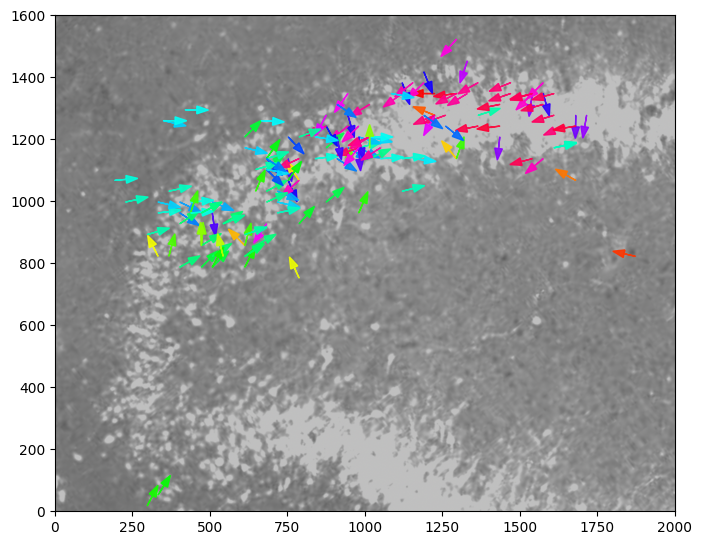

In [12]:
plot_vector_layout3( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                     xlim=(0,2000), ylim=(0,1600) )

In [7]:
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)


/tmp/ipykernel_2025/1696017225.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


In [20]:
# organize pair directions
pairs = good_pairs                      # make a copy of pairs, this avoids some bug
latencies_count = []
for i in range(len(pairs)):
    pair_latencies = latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=20)
    latencies_count.append(len(pair_latencies))
    if np.median(pair_latencies)<0:
        pairs[i] = [ pairs[i][1], pairs[i][0] ]

starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
ends = neuron_xy[ pairs[:,1] ]
centered = ends-starts   # Get the directions of arrows, then make of of them the same length
normalized = preprocessing.normalize(centered) #* 75
angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

# clump by starting pair angle counted by angle
pair_dict = {}
for i in range(len(pairs)):
    key, value = pairs[i]
    if key in pair_dict:
        pair_dict[key] = pair_dict[key] + [ angles[i] ] * latencies_count[i]
    else:
        pair_dict[key] = [ angles[i] ] * latencies_count[i]


In [9]:
i=0

In [17]:
checkit = [3]

In [15]:
checkit.append( [ angles[i] ] *  latencies_count[i] )

In [18]:
checkit + [ angles[i] ] *  latencies_count[i]

[3,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.218

In [19]:
checkit

[3]

In [56]:
latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=20)

array([-11.05,  -1.4 ,  14.9 , -17.55, -13.55,  -0.15,   6.  , -17.7 ,
       -16.35,  15.15,  -5.1 ,  12.1 , -19.9 ,  16.05,  -4.9 ,  16.05,
        16.5 ,  -6.55,   6.05,   4.35, -20.  ,  14.5 ,  11.55, -10.35,
         1.25,   5.55,  -0.55,   0.95, -18.5 ,  16.8 ,  -7.1 ,  10.3 ,
       -18.05,  -8.15,   8.45, -14.75,   2.  ,  19.5 ,  -5.5 ,   1.2 ,
        -1.5 ,  13.05,  11.55,   4.15,   8.3 ,   4.85,  -4.5 ,  13.45,
         8.95,  14.1 ,  -3.8 ,  14.8 ,  14.55,  -8.1 , -17.55, -12.8 ,
        10.05,  -1.  ,  17.5 ,  -2.05,   9.  ,  19.85,  -5.75,  11.55,
        -8.9 , -13.45,   9.2 , -11.55,  13.2 ])

/tmp/ipykernel_487/13732382.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_487/13732382.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


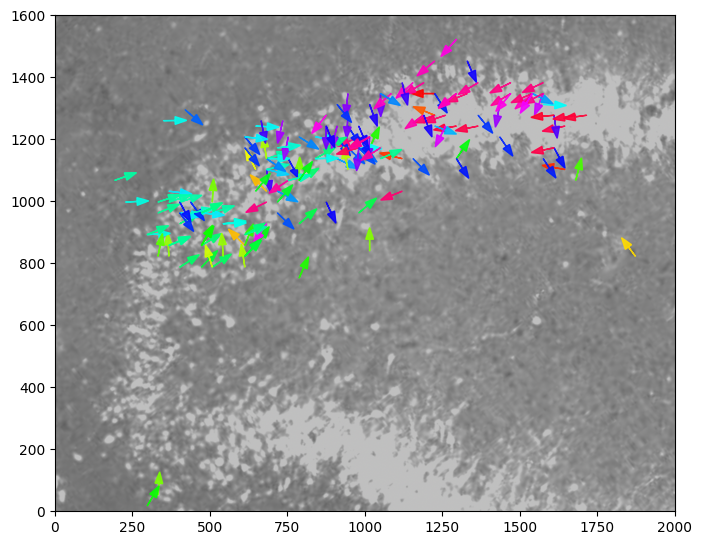

In [46]:
plot_vector_layout2( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                     xlim=(0,2000), ylim=(0,1600) )

/tmp/ipykernel_2025/4244653209.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_2025/4244653209.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


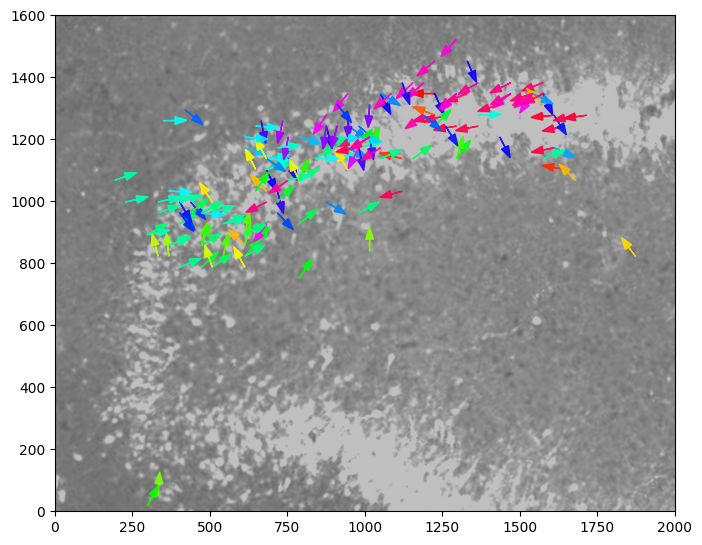

In [26]:
plot_vector_layout3( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                     xlim=(0,2000), ylim=(0,1600) )

In [17]:
neuron_xy = []
for neuron in sd.neuron_data[0].values():
    neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
neuron_xy = np.array(neuron_xy)


/tmp/ipykernel_487/1696017225.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


In [33]:

starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
ends = neuron_xy[ pairs[:,1] ]
centered = ends-starts   # Get the directions of arrows, then make of of them the same length
normalized = preprocessing.normalize(centered) #* 75
angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 
# angle = np.arctan2(-(ends[:,1]-starts[:,1]), ends[:,0]-starts[:,0]) * -1

# clump by starting pair
# pair_dict = {}
# for pair in pairs:
#     key, value = pair
#     if key in pair_dict:
#         pair_dict[key].append(value)
#     else:
#         pair_dict[key] = [value]

# clump by starting pair angle
pair_dict = {}
for i in range(len(pairs)):
    key, value = pairs[i]
    if key in pair_dict:
        pair_dict[key].append( angles[i] )
    else:
        pair_dict[key] = [ angles[i] ]

# create new dictionary of just mean angles
for key, value in pair_dict.items():
    pair_dict[key] = sum(value) / len(value)


In [34]:
pair_dict

{0: -0.12364958934728427,
 97: 1.6235696601005833,
 117: -2.817384253821941,
 1: 0.33745606922778154,
 2: 0.2961151458749647,
 63: 0.3878684920129396,
 183: -1.0782041696275029,
 158: -2.7033285371200257,
 4: 0.5287871569307246,
 74: 1.725594619350312,
 80: -0.14700065088689185,
 115: 0.9654664134132138,
 5: -1.5598889664208588,
 25: 0.5365313322973294,
 48: -1.3947800324243937,
 120: -0.7900580149572684,
 163: -0.8885767341467137,
 186: 2.761086276477428,
 6: -1.2338095854619646,
 7: 0.053618487045541285,
 81: 0.39269908169872414,
 119: -2.806577199022103,
 171: 1.380543138238714,
 29: -1.1714890195763858,
 9: -2.9206367025102864,
 182: -0.44364104277030414,
 189: -0.7578890052799306,
 10: 0.410127340541491,
 24: -0.8679431819963279,
 36: -2.4028856049834073,
 12: 0.5669032779922463,
 56: -2.4434688771440967,
 62: -1.139745495177812,
 88: 0.7990566457715358,
 13: 3.141592653589793,
 116: 1.1327673014958,
 126: -1.435748814857812,
 128: 1.5163253482999637,
 32: 2.356194490192345,
 71: 

/tmp/ipykernel_487/3981948824.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


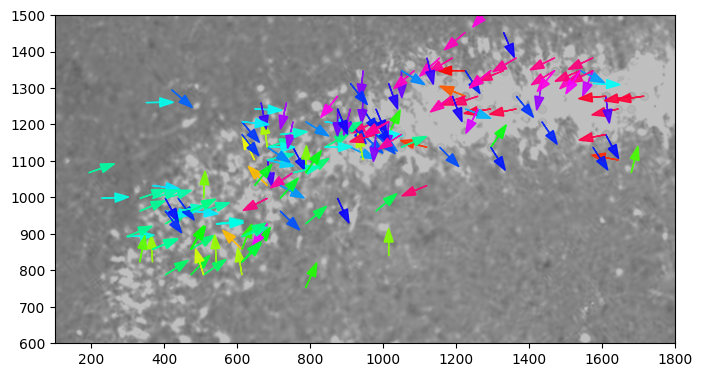

In [43]:
# Plot original scatter
plt.figure(figsize=(8, 8))
ax = plt.axes()
#ax.set_facecolor(background_color)
#if image_path is not None:
#    img = plt.imread(image_path)      # Load in image
#    plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
#if plot_neuron:
img = plt.imread("/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png")      # Load in image
plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
plt.scatter( neuron_xy[:,0], neuron_xy[:,1], alpha=0.15, c='grey')
plt.xlim( (100,1800) )
plt.ylim( 600,1500 )  


    # Draw Arrows
cmap = cm.get_cmap('hsv')
for pair, angle in pair_dict.items():
    angle2 = (angle*-1+ np.pi)/np.pi/2

    start = neuron_xy[ pair ]  
    arrow = FancyArrow( 
            start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
            linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
    plt.gca().add_patch(arrow)

In [69]:

# Calculate the angles of each vector
angles = np.arctan2( normalized[:, 1], normalized[:, 0] )




In [70]:
angles

array([ 0.21866895,  0.2624594 , -0.87605805,  1.57079633, -0.09966865,
       -2.87368223,  0.33745607,  0.29611515,  0.46364761, -2.9976672 ,
       -2.78075587,  0.42877803,  2.55359005, -1.57079633,  0.62879629,
       -2.91050199, -2.73927156,  0.70361378,  0.5880026 , -0.38050638,
        2.03444394,  2.92292371,  2.76108628, -2.57827639,  0.11065722,
        0.46364761, -0.19739556,  0.09065989,  3.14159265, -0.27829966,
       -2.76108628, -2.74814202,  0.18948016, -2.64224593,  2.35619449,
        2.03444394,  0.        , -2.90717698, -2.93409643,  0.14189705,
        0.09966865,  0.41012734, -2.03444394, -2.47254966,  0.84415399,
       -1.70632404, -2.4616838 , -2.72336832, -1.19028995,  0.73781506,
        3.14159265,  0.78539816,  0.69790282,  1.06369782,  0.69133693,
        0.60374933,  0.63976978,  3.14159265,  1.89254688,  0.69473828,
        2.96173915,  2.67794504,  2.35619449, -0.46364761,  1.37340077,
        0.30970294, -2.55359005, -2.35619449,  0.29423457,  0.52

In [67]:
angles

array([ 0.21866895,  0.2624594 , -0.87605805])

In [61]:
pair_dict

{0: [array([1.07685496, 0.81817331]),
  array([1.33654111, 0.9169863 ]),
  array([0.97538645, 0.67267055]),
  array([1.09744028, 0.76815849])],
 97: [array([0.78539816, 0.89812577]),
  array([0.68052122, 0.82619185]),
  array([0.5543075 , 0.88125731]),
  array([0.90975316, 0.80622848]),
  array([1.33654111, 1.02277241])],
 117: [array([0.28379411, 0.67973258]), array([0.23186466, 0.609806  ])],
 1: [array([1.41042088, 0.92532283])],
 2: [array([1.29733534, 0.92092588])],
 63: [array([0.88034987, 0.80325341]),
  array([0.88034987, 0.68572951]),
  array([1.33185989, 0.96262355]),
  array([1.24369823, 0.88344344])],
 183: [array([0.24497866, 0.70492715]),
  array([0.28546286, 0.6314535 ]),
  array([0.67738644, 0.8547313 ])],
 158: [array([0.39004807, 0.64147271]),
  array([0.55659932, 0.60817278]),
  array([0.55659932, 0.70339072])],
 4: [array([1.19326613, 0.91580147]), array([1.09829939, 0.91580147])],
 74: [array([0.58138018, 0.86685021]),
  array([0.58138018, 0.78539816]),
  array([0.

In [65]:
pair_dict[0] 

[array([1.07685496, 0.81817331]),
 array([1.33654111, 0.9169863 ]),
 array([0.97538645, 0.67267055]),
 array([1.09744028, 0.76815849])]

In [55]:
pair_dict

{0: [array([1.07685496, 0.81817331]),
  array([1.33654111, 0.9169863 ]),
  array([0.97538645, 0.67267055]),
  array([1.09744028, 0.76815849])],
 97: [array([0.78539816, 0.89812577]),
  array([0.68052122, 0.82619185]),
  array([0.5543075 , 0.88125731]),
  array([0.90975316, 0.80622848]),
  array([1.33654111, 1.02277241])],
 117: [array([0.28379411, 0.67973258]), array([0.23186466, 0.609806  ])],
 1: [array([1.41042088, 0.92532283])],
 2: [array([1.29733534, 0.92092588])],
 63: [array([0.88034987, 0.80325341]),
  array([0.88034987, 0.68572951]),
  array([1.33185989, 0.96262355]),
  array([1.24369823, 0.88344344])],
 183: [array([0.24497866, 0.70492715]),
  array([0.28546286, 0.6314535 ]),
  array([0.67738644, 0.8547313 ])],
 158: [array([0.39004807, 0.64147271]),
  array([0.55659932, 0.60817278]),
  array([0.55659932, 0.70339072])],
 4: [array([1.19326613, 0.91580147]), array([1.09829939, 0.91580147])],
 74: [array([0.58138018, 0.86685021]),
  array([0.58138018, 0.78539816]),
  array([0.

In [43]:
# Get the x/y locations of the start and end neurons of each pair
neuron_xy = []
for neuron in sd.neuron_data[0].values():
    neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
neuron_xy = np.array(neuron_xy)

starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
ends = neuron_xy[ pairs[:,1] ]
centered = ends-starts   # Get the directions of arrows, then make of of them the same length
normalized = preprocessing.normalize(centered) #* 75

/tmp/ipykernel_2342/1619751503.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


In [42]:
#normalized

In [44]:
normalized

array([[ 0.97618706,  0.21693046],
       [ 0.96575479,  0.25945651],
       [ 0.6401844 , -0.76822128],
       [ 0.        ,  1.        ],
       [ 0.99503719, -0.09950372],
       [-0.96432615, -0.26471698],
       [ 0.94359998,  0.33108771],
       [ 0.95647733,  0.29180664],
       [ 0.89442719,  0.4472136 ],
       [-0.9896606 , -0.14342907],
       [-0.93560172, -0.35305725],
       [ 0.90947448,  0.41575976],
       [-0.83205029,  0.5547002 ],
       [ 0.        , -1.        ],
       [ 0.80873608,  0.5881717 ],
       [-0.97341717, -0.22903933],
       [-0.92015464, -0.39155516],
       [ 0.76250914,  0.64697745],
       [ 0.83205029,  0.5547002 ],
       [ 0.92847669, -0.37139068],
       [-0.4472136 ,  0.89442719],
       [-0.97618706,  0.21693046],
       [-0.92847669,  0.37139068],
       [-0.8454889 , -0.53399299],
       [ 0.99388373,  0.11043153],
       [ 0.89442719,  0.4472136 ],
       [ 0.98058068, -0.19611614],
       [ 0.99589321,  0.09053575],
       [-1.        ,

In [ ]:
[[ 0.97618706,  0.21693046],
[ 0.96575479,  0.25945651],
[ 0.6401844 , -0.76822128],
]

In [47]:
pairs[0:3]

array([[ 0, 52],
       [ 0, 78],
       [ 0, 91]])

In [32]:
preprocessing.normalize

<function sklearn.preprocessing._data.normalize(X, norm='l2', *, axis=1, copy=True, return_norm=False)>

In [23]:
i=0

In [25]:
pair_dict[i]

[52, 78, 91, 105]

In [16]:
good_pairs

array([[  0,  52],
       [  0,  78],
       [  0,  91],
       [ 97,   0],
       [  0, 105],
       [117,   0],
       [  1,  37],
       [  2,  27],
       [ 63,   2],
       [183,   2],
       [158,   3],
       [  4,  33],
       [ 74,   4],
       [ 80,   4],
       [  4,  96],
       [115,   4],
       [  5,  19],
       [ 25,   5],
       [ 48,   5],
       [  5, 119],
       [120,   5],
       [163,   5],
       [186,   5],
       [  6,  51],
       [  6, 162],
       [  7,  21],
       [  7,  30],
       [  7,  43],
       [ 81,   7],
       [  7,  91],
       [117,   7],
       [119,   7],
       [  7, 184],
       [ 48,   8],
       [ 97,   8],
       [171,   8],
       [ 29,   9],
       [  9,  92],
       [  9, 100],
       [182,   9],
       [189,   9],
       [ 10, 158],
       [ 24,  12],
       [ 36,  12],
       [ 12,  52],
       [ 12,  53],
       [ 56,  12],
       [ 62,  12],
       [ 12,  63],
       [ 12,  69],
       [ 12,  74],
       [ 12, 100],
       [ 12,

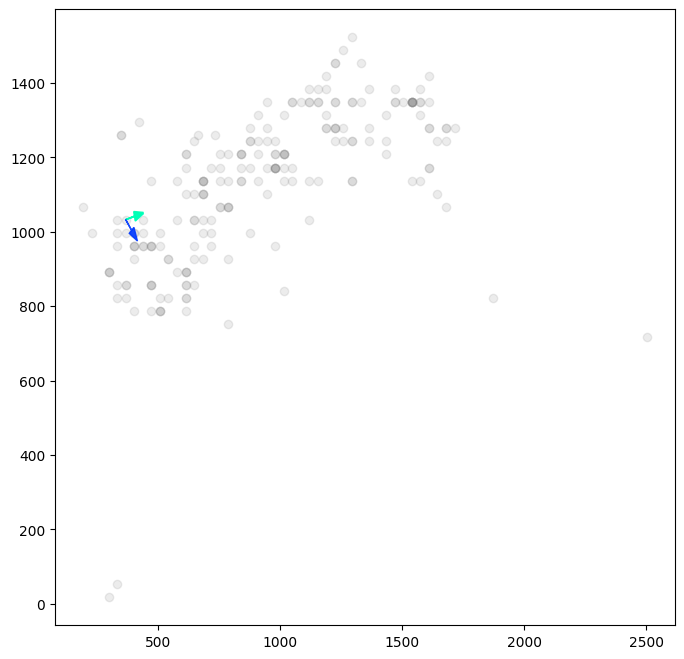

In [50]:
plot_vector_layout( sd, good_pairs[0:3])

# Vector Plots

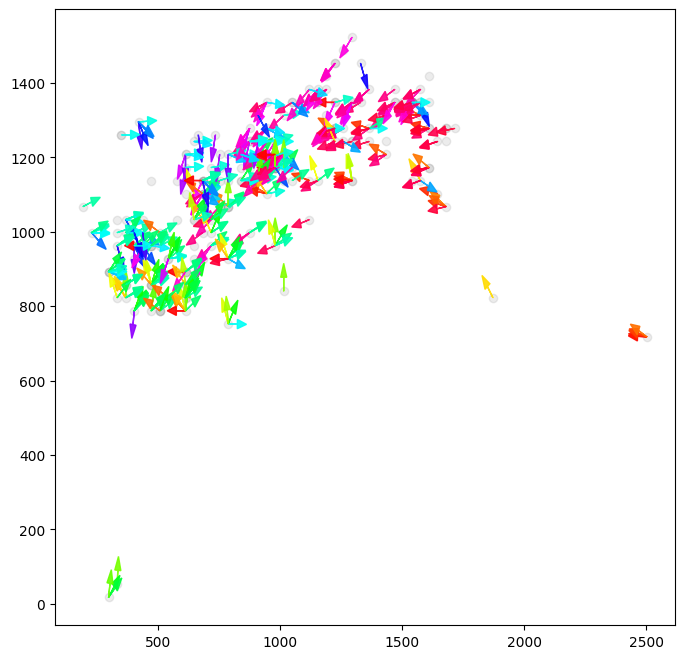

In [8]:
plot_vector_layout( sd, good_pairs)

In [8]:
@interact_manual(num=(0,len(good_pairs)-1))
def analyzePair(num):
    plot_pair_analysis( good_pairs[num][0], good_pairs[num][1], sd)

interactive(children=(IntSlider(value=232, description='num', max=465), Button(description='Run Interact', sty…

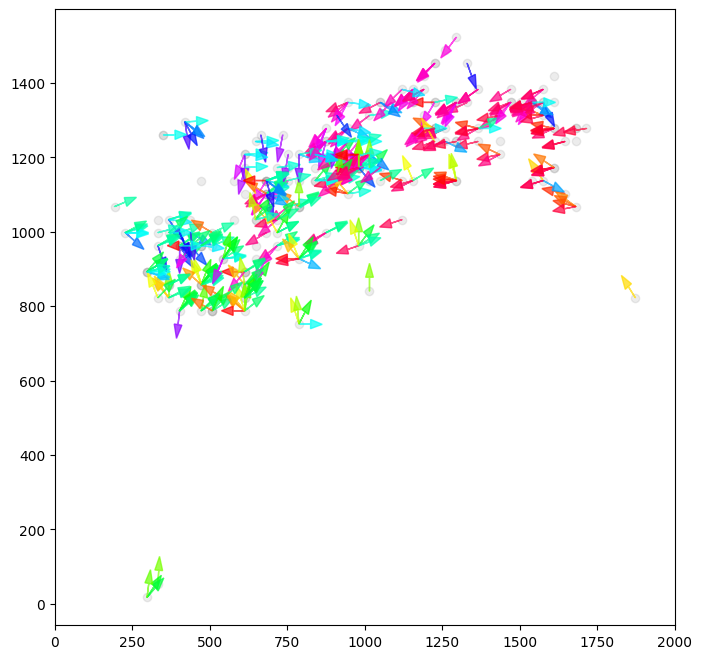

In [7]:
plot_vector_layout( sd, good_pairs,  xlim=(0,2000) )

/tmp/ipykernel_1464/3989538213.py:14: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_1464/3989538213.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


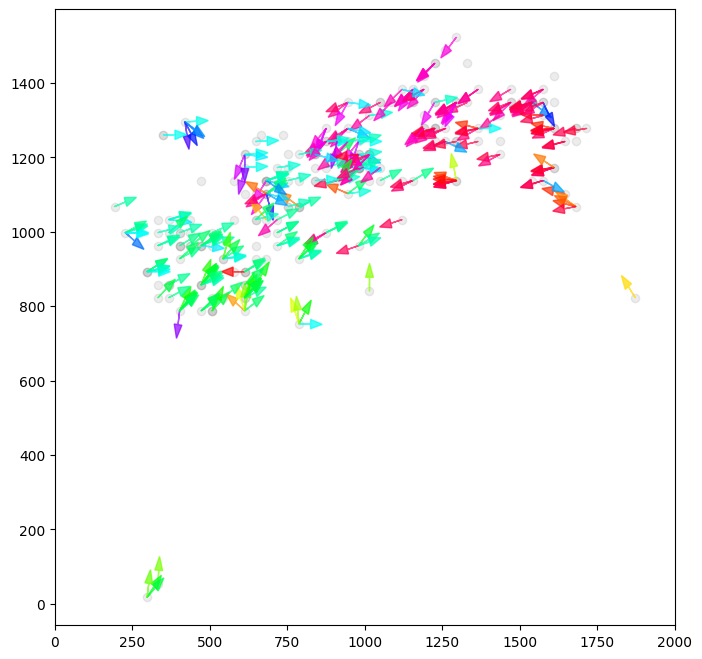

In [11]:
plot_vector_layout( sd, good_pairs, min_dist=300, xlim=(0,2000) )

/tmp/ipykernel_24052/2995960396.py:28: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_24052/2995960396.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


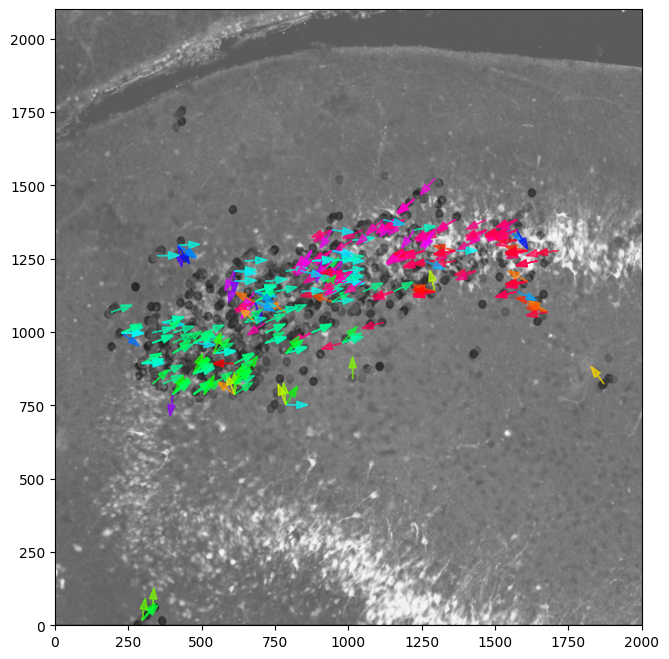

In [16]:
plot_vector_layout( sd, good_pairs, min_dist=300, xlim=(0,2000), image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw.jpeg" )

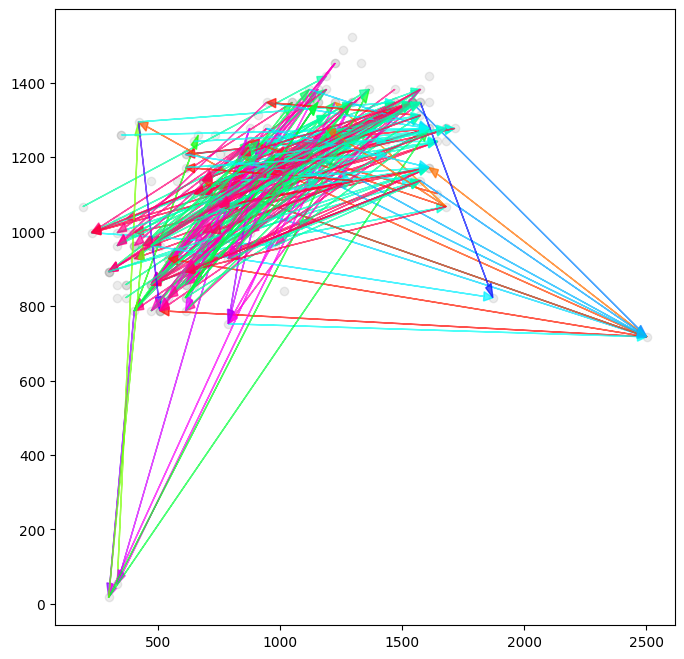

In [13]:
plot_vector_layout( sd, good_pairs, min_dist=500, normalize=False )

# Make Animations

In [15]:
animate_latencies(plot_vector=True, ms_range=range(0,1000) )

<function human_hip.animate.animate_latency_pairs.animate_latencies(sd, pairs, movie_range_ms=None, frame_interval_ms=500, directed=True, directed_backwards=False, filename='latencies.mp4', latency_ms_cutoff_low=1, latency_ms_cutoff_high=15, plot_vector=False, min_dist=0)>

25781 latency events occured in total spikedata
Making animation of 3.008 minutes
Saved animation to media/latencies.mp4


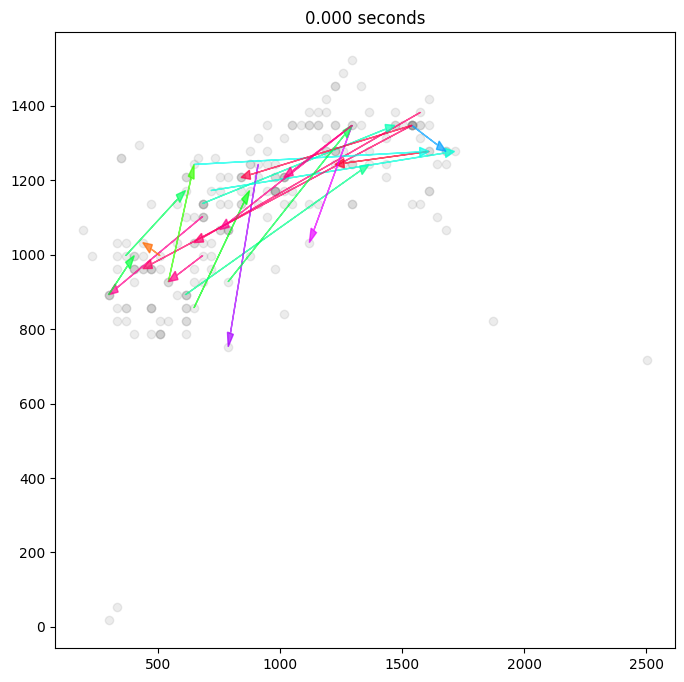

In [14]:
animate_latencies(sd, good_pairs, filename="media/latencies.mp4" )

1860 latency events occured in total spikedata
668 latency events occured above 500 um distance
Making animation of 2.283 minutes
Saved animation to media/latencies_mindist500.mp4


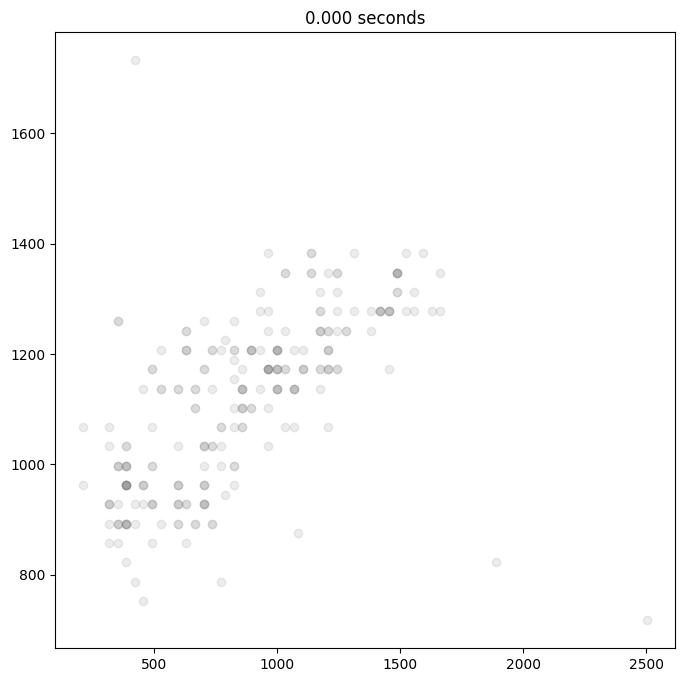

In [13]:
animate_latencies(sd, good_pairs,  filename='media/latencies_mindist500.mp4', min_dist=500 )

In [ ]:
# animate_latencies(sd, pairs, movie_range_ms=None, frame_interval_ms=500, directed=True, filename="latencies.mp4",
#                       latency_ms_cutoff_low=0, latency_ms_cutoff_high=15 ):